## Ideas with Data Transformation / New Features

This notebook was actually much messier before, but it's basically a collection of notes/code I used to show why I transformed the data that I did, what outliers I got rid of, and what results I got. Hope it makes some sense..

In [79]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# To plot matplotlib figures inline on the notebook
%matplotlib inline

In [80]:
train_df = pd.read_csv('../data/train.csv')

In [81]:
plt.rcParams['figure.figsize'] = (12.0, 6.0) # making any plots larger now so I don't have to do set it later on

### Looking at any outliers in the target variable, Sale Price

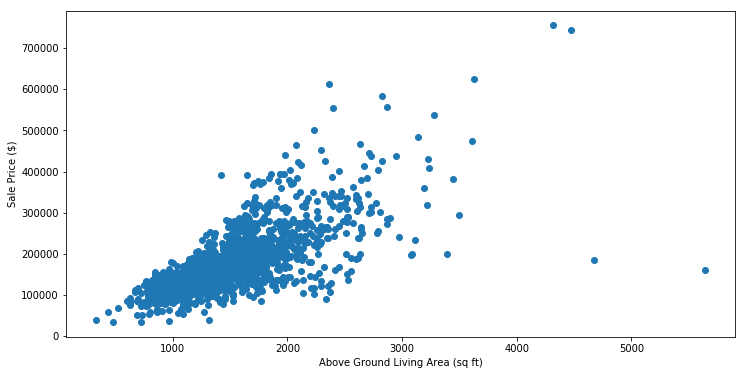

In [82]:
plt.scatter(x=train_df.GrLivArea, y=train_df.SalePrice)
plt.xlabel('Above Ground Living Area (sq ft)')
plt.ylabel('Sale Price ($)')
plt.show()

At `GrLivArea` > 4000, it seems like those points are outliers. Dropping them from the train_df dataset.

In [83]:
print('Dimensions prior to dropping the outliers: ' + str(train_df.shape))
train_df = train_df[train_df.GrLivArea < 4000]
print('Dimensions after dropping outliers: ' + str(train_df.shape))

Dimensions prior to dropping the outliers: (1460, 81)
Dimensions after dropping outliers: (1456, 81)


### Adding one feature I feel like would be very helpful, total square footage

In [84]:
train_df['TotalSF'] = (train_df['BsmtFinSF1'].fillna(0) +
                       train_df['BsmtFinSF2'].fillna(0) +
                       train_df['1stFlrSF'].fillna(0) +
                       train_df['2ndFlrSF'].fillna(0))

### Looking at the distribution of the target variable, Sale Price

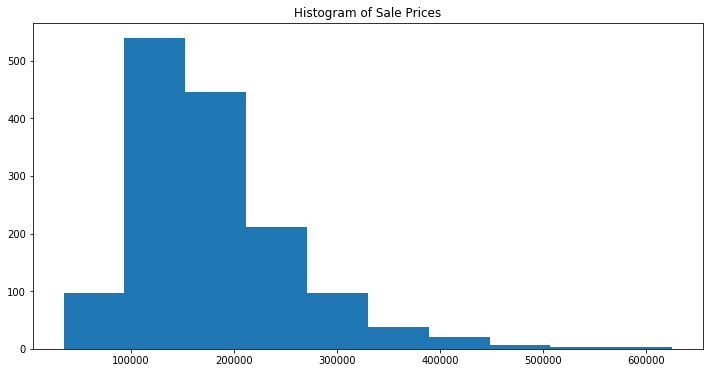

In [85]:
plt.hist(train_df.SalePrice)
plt.title('Histogram of Sale Prices')
plt.show()

Applying `np.log1p()` to the data, to see if the log transform helps avoid the right-skew:

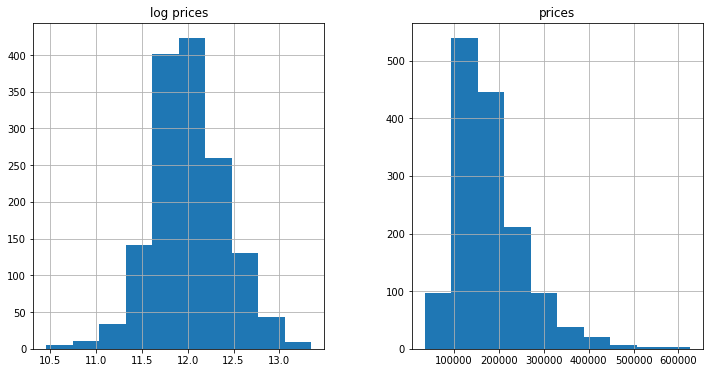

In [86]:
prices_transf = pd.DataFrame({'prices': train_df.SalePrice,
                              'log prices': np.log1p(train_df.SalePrice)}) # doing log1p to avoid ln(0) should it arrive later
prices_transf.hist()
plt.show()

In [87]:
train_df.SalePrice = np.log1p(train_df.SalePrice)

If there are any other skewed variables in our dataset, we should also transform them to preserver normality.

In [88]:
train_df.info() # looking for columns of dtype = 'int' or 'float', basically not an object

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1459
Data columns (total 82 columns):
Id               1456 non-null int64
MSSubClass       1456 non-null int64
MSZoning         1456 non-null object
LotFrontage      1197 non-null float64
LotArea          1456 non-null int64
Street           1456 non-null object
Alley            91 non-null object
LotShape         1456 non-null object
LandContour      1456 non-null object
Utilities        1456 non-null object
LotConfig        1456 non-null object
LandSlope        1456 non-null object
Neighborhood     1456 non-null object
Condition1       1456 non-null object
Condition2       1456 non-null object
BldgType         1456 non-null object
HouseStyle       1456 non-null object
OverallQual      1456 non-null int64
OverallCond      1456 non-null int64
YearBuilt        1456 non-null int64
YearRemodAdd     1456 non-null int64
RoofStyle        1456 non-null object
RoofMatl         1456 non-null object
Exterior1st      1456 non-n

In [89]:
numeric_feat = train_df.dtypes[train_df.dtypes != "object"]
numeric_feat = numeric_feat.drop('Id')
numeric_feat = numeric_feat.index
numeric_feat

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'TotalSF'],
      dtype='object')

Assessing the skewness of all the above features:

In [90]:
from scipy.stats import skew

skew_feat = train_df[numeric_feat].apply(lambda x: skew(x.fillna(0)))
skew_feat.sort_values(ascending=False)

MiscVal          24.418175
PoolArea         17.504556
LotArea          12.574590
3SsnPorch        10.279262
LowQualFinSF      8.989291
KitchenAbvGr      4.476748
BsmtFinSF2        4.244209
BsmtHalfBath      4.124712
ScreenPorch       4.111400
EnclosedPorch     3.081275
MasVnrArea        2.654761
OpenPorchSF       2.337435
WoodDeckSF        1.549672
MSSubClass        1.404916
BsmtUnfSF         0.920809
1stFlrSF          0.866187
GrLivArea         0.834332
TotalSF           0.826638
2ndFlrSF          0.777065
BsmtFinSF1        0.744088
OverallCond       0.689919
HalfBath          0.683518
TotRmsAbvGrd      0.660735
Fireplaces        0.632026
BsmtFullBath      0.590543
TotalBsmtSF       0.485894
MoSold            0.217659
BedroomAbvGr      0.214845
OverallQual       0.183681
GarageArea        0.132854
YrSold            0.093118
SalePrice         0.065393
FullBath          0.017675
LotFrontage      -0.005543
GarageCars       -0.343121
YearRemodAdd     -0.499316
YearBuilt        -0.609458
G

So, this next part involves finding out a cutoff skewness, to log-transform anything above a certain point. After looking at [this link](https://stats.stackexchange.com/questions/245835/range-of-values-of-skewness-and-kurtosis-for-normal-distribution), I've settled on 0.75, seems like it's right in the middle for 'medium' skewness. Again, we should probably talk about this more in person.

In [91]:
skew_feat = skew_feat[skew_feat > 0.75].index
skew_feat

Index(['MSSubClass', 'LotArea', 'MasVnrArea', 'BsmtFinSF2', 'BsmtUnfSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath',
       'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'TotalSF'],
      dtype='object')

In [92]:
train_df[skew_feat] = np.log1p(train_df[skew_feat])

### Going to go with some basic modelling here

This is kind of still up in the air, I'm just doing lasso regularization on a linear model because that's just what we've decided right?

In [93]:
# data pre-processing
train_df = train_df.fillna(0)

In [94]:
# grab the categorical variables
df_categorical = train_df.select_dtypes(include=['object'])
# print out the names
df_categorical.columns;
# make a copy for modifications
df = train_df.copy()

In [95]:
# runs through categorical columns and does 2 things
# 1) dummy out (and remove redundant dummy)
# 2) remove original categorical variable
for i in df_categorical.columns:
    df = df.join(pd.get_dummies(df[i], prefix = i, prefix_sep = '_', drop_first=True))
    df = df.drop(i, 1)

In [96]:
# many more variables now but NONE are categorical
print(train_df.shape)
print(df.shape)

(1456, 82)
(1456, 263)


In [97]:
X = df.loc[:, df.columns != 'SalePrice']
X = X.loc[:, X.columns != 'Id']
y = df['SalePrice']

In [98]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [41]:
from sklearn import linear_model
ols = linear_model.LinearRegression()

ols.fit(X_train, y_train)
print("R^2 for train set: %f" %ols.score(X_train, y_train))
print('-'*50)
print("R^2 for test  set: %f" %ols.score(X_test, y_test))

R^2 for train set: 0.958026
--------------------------------------------------
R^2 for test  set: 0.802538


/Users/joshvichare/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


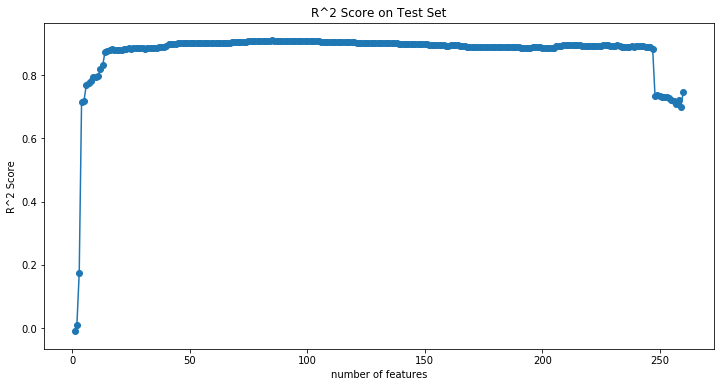

In [42]:
n = range(1, X_train.shape[1])
r2_vec_test = []
for i in n:
    ols.fit(X_train.iloc[:, 0:i] , y_train)
    r2_vec_test.append(ols.score(X_test.iloc[:, 0:i] , y_test))
plt.scatter(n, r2_vec_test)
plt.plot(n, r2_vec_test)
plt.xlabel('number of features')
plt.ylabel('R^2 Score')
plt.title('R^2 Score on Test Set')
plt.show()

#### Not that high, instead of limiting the amount of features via just 1:n features in a set order, going to work on lasso regularization:

In [99]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

# found this useful helper function to calculate RMSE for lasso/ridge regularization thanks to Stack Overflow
# honestly, don't know why the cross_val_score spits out a negative value so we have to take the neg to take the sqrt..
def mse_cv(model, X, y):
    mse= -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5)
    return(mse)

In [110]:
alpha_val = [1, 0.1, 0.001, 0.0005]
model_lasso = LassoCV(alphas = alpha_val).fit(X_train, y_train)
model_lasso.score(X_train, y_train)

0.9349949076478241

In [111]:
mse_cv(model_lasso, X_train, y_train).mean()

0.012709560681861493

That's a low **MSE**, going to inspect whatever variables were left, and whichever ones were most important:

In [112]:
beta_vals = pd.Series(model_lasso.coef_, index = X_train.columns)

print("Variables kept: " + str(sum(beta_vals != 0)))
print("Variables eliminated: " + str(sum(beta_vals == 0)))

Variables kept: 74
Variables eliminated: 187


In [113]:
print(beta_vals.sort_values().head(10))
print(beta_vals.sort_values().tail(10))

BldgType_Duplex       -0.026708
KitchenQual_TA        -0.025780
BsmtCond_Fa           -0.024355
Neighborhood_IDOTRR   -0.020754
KitchenQual_Gd        -0.016678
BsmtQual_TA           -0.012352
BedroomAbvGr          -0.009813
BsmtExposure_No       -0.008816
Exterior2nd_HdBoard   -0.007838
Foundation_CBlock     -0.006683
dtype: float64
BsmtQual_Ex             0.052480
OverallQual             0.061975
MSZoning_FV             0.063194
SaleCondition_Normal    0.066271
Exterior1st_BrkFace     0.078234
LotArea                 0.079908
Neighborhood_Crawfor    0.090926
TotalSF                 0.116330
SaleType_New            0.116360
GrLivArea               0.203665
dtype: float64


Looking one step furthur at the most important coefficients:

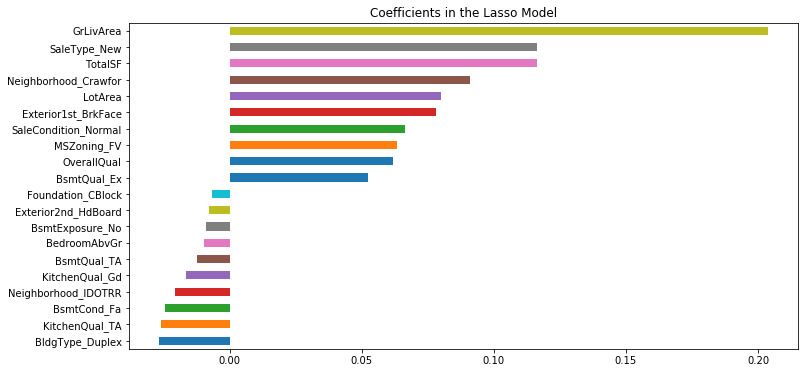

In [114]:
important_feat = pd.concat([beta_vals.sort_values().head(10), beta_vals.sort_values().tail(10)])

important_feat.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

### Making a set of predictions and calculating the error:

In [115]:
# confirming that the features haven't changed between the train and test sets..
print(X_train.shape)
print(X_test.shape)

(1019, 261)
(437, 261)


In [116]:
# defining how to calculate RMSE between predictions and target values:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# defining how to calculate RMSLE (kaggle competition metric) betwerrn predictions and target values:
def rmsle(predictions, targets): 
    return np.sqrt(np.square(np.log1p(predictions) - np.log1p(targets)).mean())

In [117]:
pred = model_lasso.predict(X_test)
target = y_test

print("RMSE value: " + str(rmse(pred, y_test)))
print("RMSLE value: " + str(rmsle(pred, y_test)))

RMSE value: 0.11940307061745822
RMSLE value: 0.009372003453644567


### That's really low, going to run this on the whole dataset and see what I get.

Going to make a full dataframe, concatonating the train and test data, then run through the feature generation as I did above. I'm copying all the importing and whatnot, just so you can run the notebook straight from this location in the future.

In [53]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# To plot matplotlib figures inline on the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0) # making any plots larger now so I don't have to do set it later on

In [54]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [55]:
all_sales = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                       test.loc[:,'MSSubClass':'SaleCondition']))

In [56]:
# imputation on the NA vals, for lot frontage, filling any NA values with median of that column
# for other columns, just setting NA vals to 0

all_sales.LotFrontage = all_sales.LotFrontage.fillna(all_sales.LotFrontage.median())
all_sales = all_sales.fillna(0)

In [57]:
all_sales['TotalSF'] = (all_sales['BsmtFinSF1'].fillna(0) +
                        all_sales['BsmtFinSF2'].fillna(0) +
                        all_sales['1stFlrSF'].fillna(0) +
                        all_sales['2ndFlrSF'].fillna(0))

In [58]:
# removing any outliers from the training dataset
train = train[train.GrLivArea < 4000]

In [59]:
# repeating the skewness testing and transformation
train.SalePrice = np.log1p(train.SalePrice)

numeric_feat = all_sales.dtypes[all_sales.dtypes != "object"].index
numeric_feat

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'TotalSF'],
      dtype='object')

In [60]:
from scipy.stats import skew

skew_feat = all_sales[numeric_feat].apply(lambda x: skew(x))
print(skew_feat.sort_values(ascending=False))

skew_feat = skew_feat[skew_feat > 0.75].index
print(skew_feat)

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
MasVnrArea        2.613592
OpenPorchSF       2.535114
WoodDeckSF        1.842433
TotalSF           1.834437
LotFrontage       1.674852
1stFlrSF          1.469604
BsmtFinSF1        1.425230
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
OverallCond       0.570312
BedroomAbvGr      0.326324
GarageArea        0.239257
OverallQual       0.197110
MoSold            0.195884
FullBath          0.167606
YrSold            0.132399
GarageCars       -0.219581
YearRemodAdd     -0.451020
YearBuilt        -0.599806
GarageYrBlt      -3.906205
d

In [61]:
all_sales[skew_feat] = np.log1p(all_sales[skew_feat])

In [62]:
# grab the categorical variables
df_categorical = all_sales.select_dtypes(include=['object'])
# print out the names
print(df_categorical.columns)
# make a copy for modifications
df = all_sales.copy()

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [63]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,0,1,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,0,1,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,0,1,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,0,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,0,1,0,0,0,1,0


# The following cell takes forever to run, not sure what the cause is, should look at it tomorrow:

In [64]:
# runs through categorical columns and does 2 things
# 1) dummy out (and remove redundant dummy)
# 2) remove original categorical variable
#for i in df_categorical.columns:
#    df = df.join(pd.get_dummies(df[i], prefix = i, prefix_sep = '_', drop_first=True))
#    df = df.drop(i, 1)

In [65]:
# many more variables now but NONE are categorical
print(all_sales.shape)
print(df.shape)

(2919, 80)
(2919, 269)


In [67]:
X_train = df[:train.shape[0]]
X_test = df[train.shape[0]:]
y = train.SalePrice

In [68]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

# found this useful helper function to calculate RMSE for lasso/ridge regularization thanks to Stack Overflow
# honestly, don't know why the cross_val_score spits out a negative value so we have to take the neg to take the sqrt..
def mse_cv(model, X, y):
    mse= -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5)
    return(mse)

In [69]:
alpha_val = [1, 0.1, 0.001, 0.0005]
model_lasso = LassoCV(alphas = alpha_val).fit(X_train, y)
model_lasso.score(X_train, y)

0.0676177083839613

In [70]:
mse_cv(model_lasso, X_train, y).mean()

0.15727833935909072

In [71]:
beta_vals = pd.Series(model_lasso.coef_, index = X_train.columns)

print("Variables kept: " + str(sum(beta_vals != 0)))
print("Variables eliminated: " + str(sum(beta_vals == 0)))

Variables kept: 2
Variables eliminated: 267


In [72]:
print(beta_vals.sort_values().head(10))
print(beta_vals.sort_values().tail(10))

MSSubClass        -0.0
BsmtQual_Gd        0.0
BsmtQual_TA       -0.0
BsmtCond_Fa       -0.0
BsmtCond_Gd       -0.0
BsmtCond_Po       -0.0
BsmtCond_TA        0.0
BsmtExposure_Av    0.0
BsmtExposure_Gd    0.0
BsmtExposure_Mn    0.0
dtype: float64
SaleCondition_Partial    0.000000
Condition2_Feedr        -0.000000
Condition1_RRNn         -0.000000
Condition1_RRNe          0.000000
Condition1_RRAn          0.000000
Condition1_RRAe         -0.000000
Condition1_PosN          0.000000
Condition2_Norm          0.000000
YearBuilt                0.000336
GarageArea               0.000421
dtype: float64


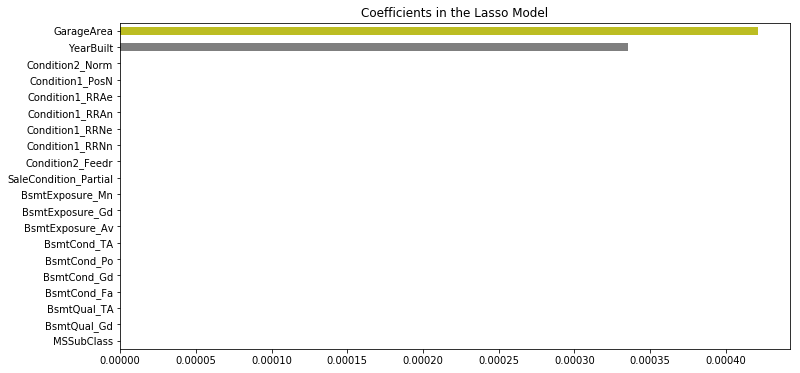

In [73]:
important_feat = pd.concat([beta_vals.sort_values().head(10), beta_vals.sort_values().tail(10)])

important_feat.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

In [74]:
# confirming that the features haven't changed between the train and test sets..
print(X_train.shape)
print(X_test.shape)

(1456, 269)
(1463, 269)


In [75]:
# defining how to calculate RMSE between predictions and target values:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# defining how to calculate RMSLE (kaggle competition metric) betwerrn predictions and target values:
def rmsle(predictions, targets): 
    return np.sqrt(np.square(np.log1p(predictions) - np.log1p(targets)).mean())

In [77]:
pred = model_lasso.predict(X_test)

#print("RMSE value: " + str(rmse(pred, y)))
#print("RMSLE value: " + str(rmsle(pred, y)))